# Decision Tree Classifier

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("darkgrid")

In [2]:
## Import packages
## tree will be used to plot the decisiton tree
from sklearn import tree

## This is the actual out of the box algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score,accuracy_score

In [3]:
#import cleaned CSV (no date information)
cmm_pa_clf_read = pd.read_csv("../Data/cmm_pa_clf.csv",index_col = 0)

cmm_pa_clf_data = cmm_pa_clf_read.drop(columns = 'pa_approved').copy()
cmm_pa_clf_target = cmm_pa_clf_read['pa_approved'].copy()
X_train,X_test,y_train,y_test= train_test_split(cmm_pa_clf_data, cmm_pa_clf_target, test_size = 0.2, 
                                             random_state = 10475, shuffle = True,
                                            stratify = cmm_pa_clf_target)

In [5]:
#kfold cross validation for roc_auc, accuracy
kfold = StratifiedKFold(5, shuffle=True, random_state=10475)
depth = range(3,15)

cv_accs = np.zeros((5, len(depth)))
cv_aucs = np.zeros((5, len(depth)))


i = 0
for train_index, test_index in  kfold.split(X_train, y_train):
    X_train_train = X_train.iloc[train_index]
    X_holdout = X_train.iloc[test_index]
    y_train_train  =  y_train.iloc[train_index]
    y_holdout = y_train.iloc[test_index]
    
    j = 0
    for d in depth:
        dtree=DecisionTreeClassifier(max_depth=d,random_state=10475)
        dtree.fit(X_train_train, y_train_train)
        
        cv_accs[i,j] = accuracy_score(y_holdout, dtree.predict(X_holdout))
        cv_aucs[i,j] = roc_auc_score(y_holdout, dtree.predict_proba(X_holdout)[:,1])
        j = j + 1
    i = i + 1

In [6]:
print(np.mean(cv_accs,axis=0))
print(np.mean(cv_aucs,axis=0))

[0.78744491 0.80917349 0.81295305 0.81406152 0.81372426 0.81372426
 0.81372426 0.81372426 0.81372426 0.81372426 0.81372426 0.81372426]
[0.83694374 0.86418024 0.87560508 0.8776088  0.87808599 0.87808968
 0.87808968 0.87808968 0.87808968 0.87808968 0.87808968 0.87808968]


In [14]:
dtree=DecisionTreeClassifier(max_depth=6,random_state=10475)
fig=dtree.fit(X_train, y_train)

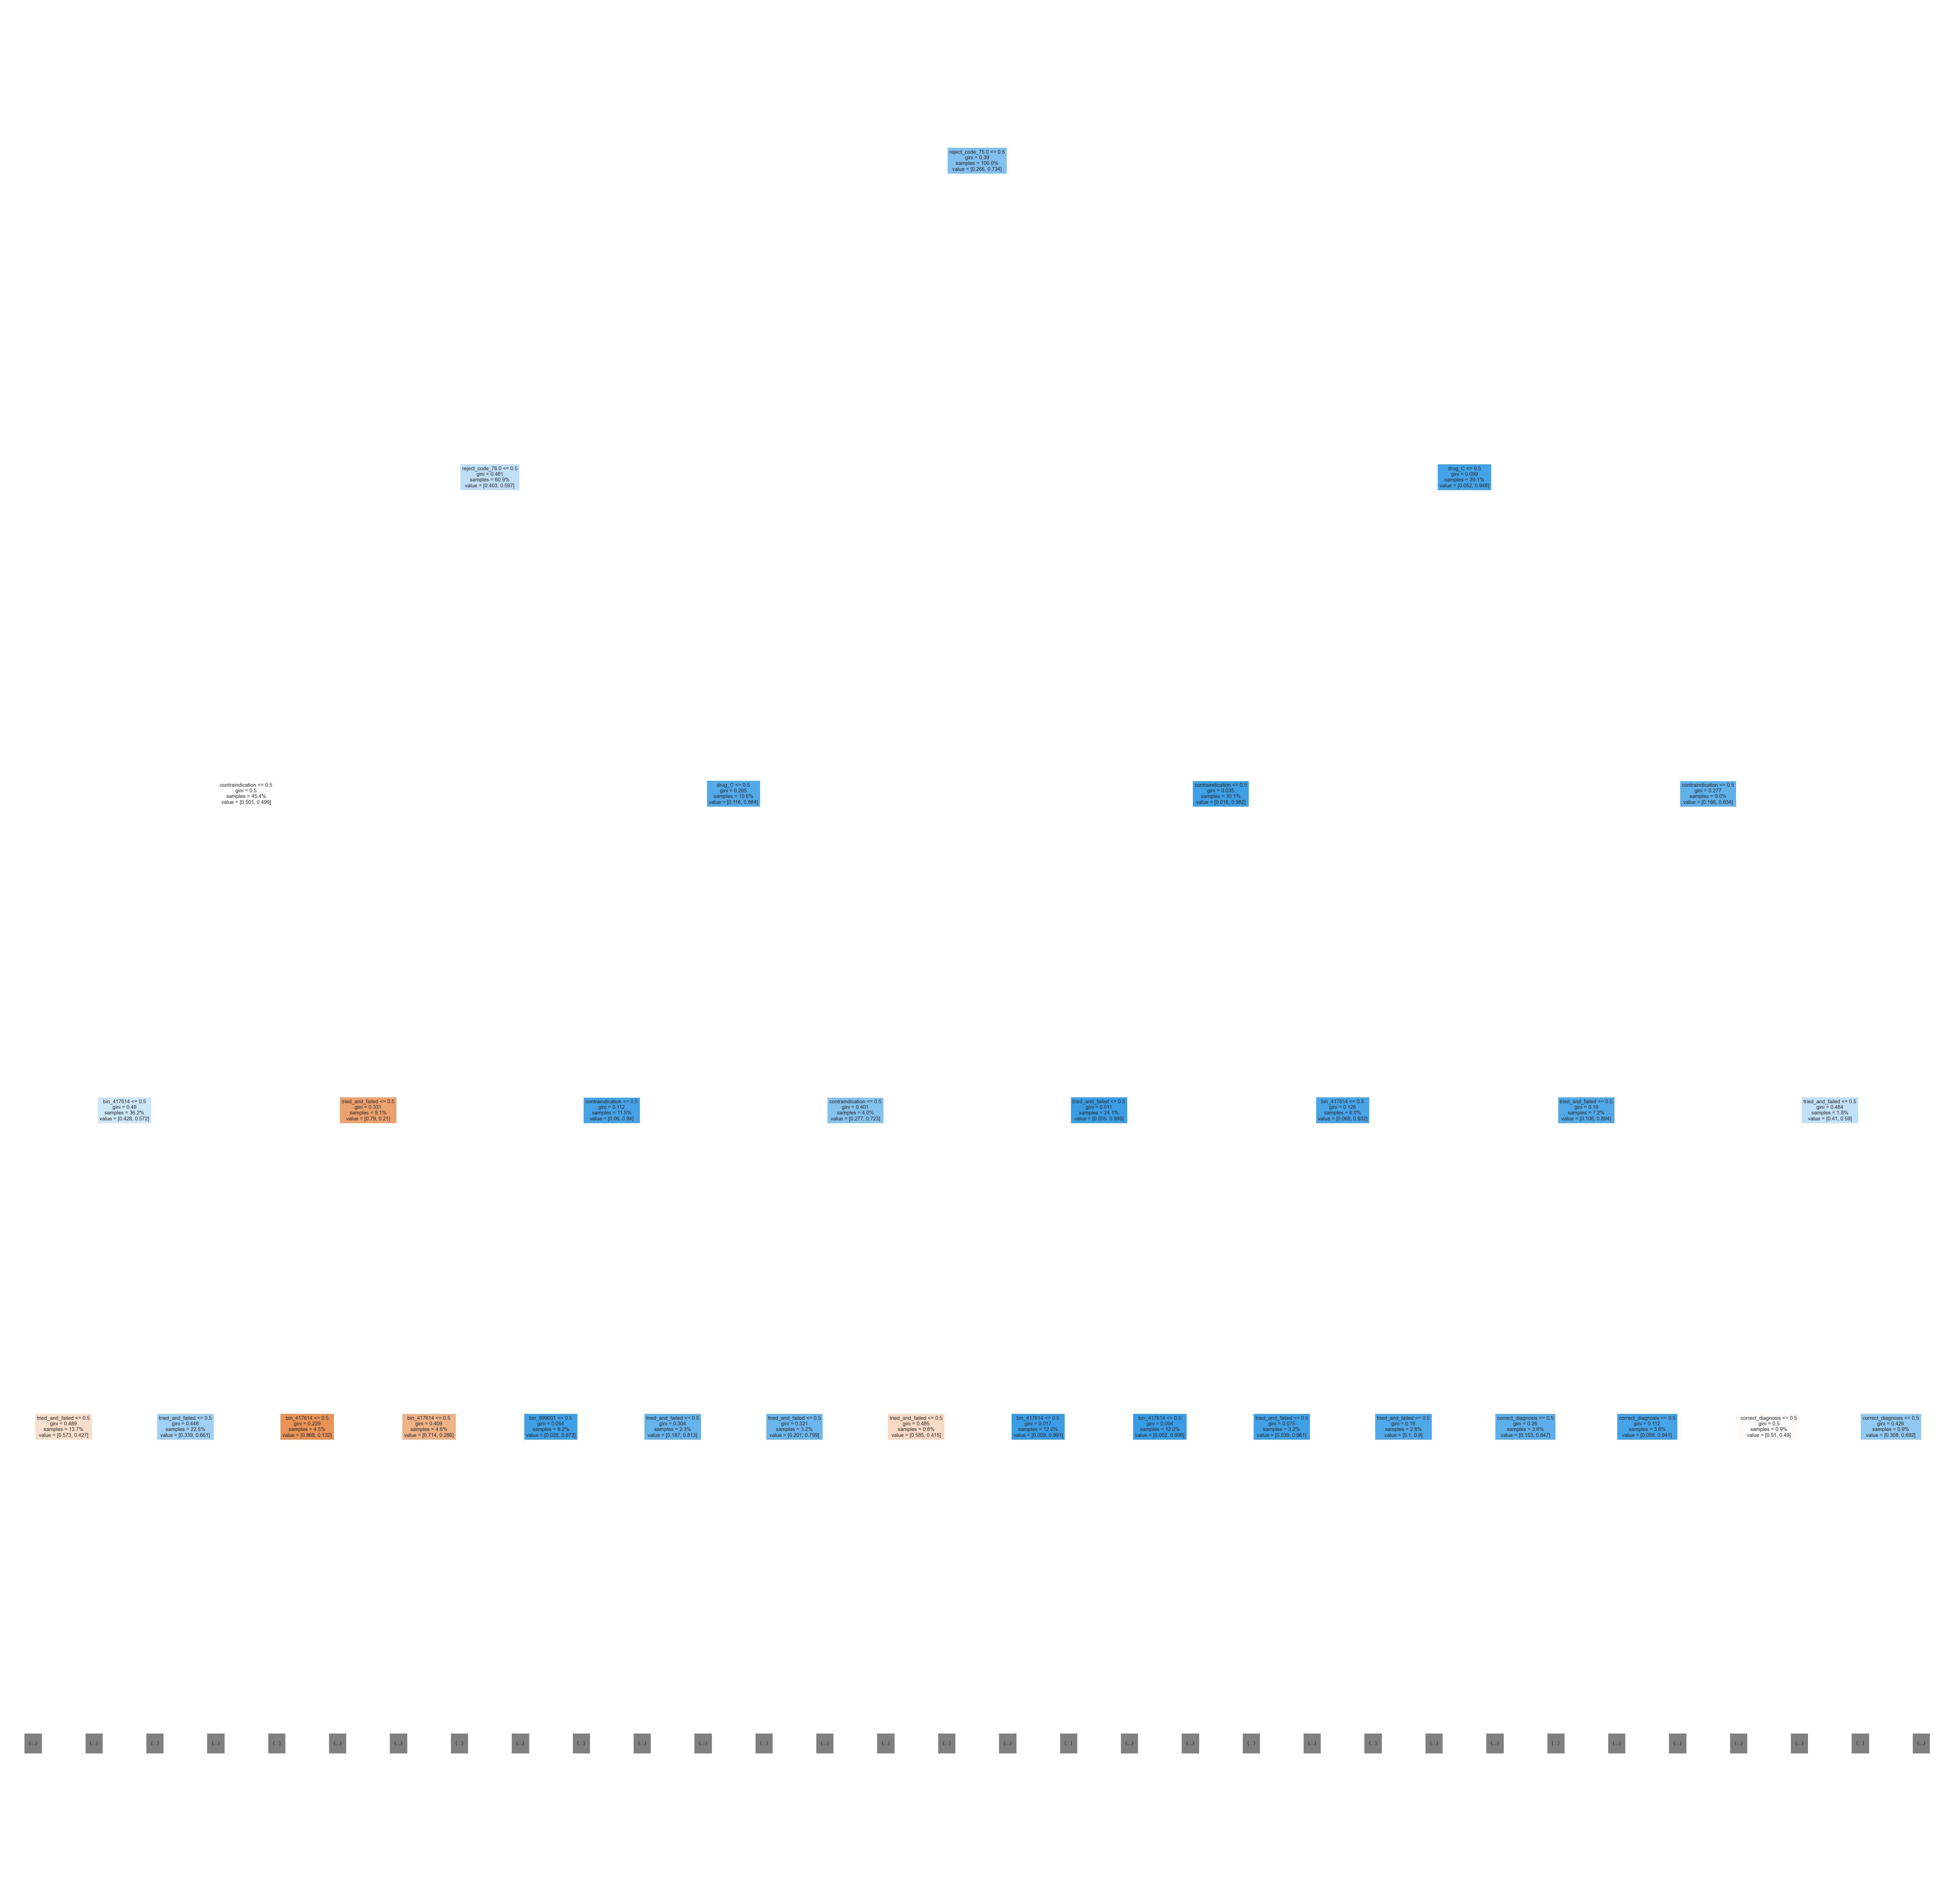

In [27]:
plt.figure(figsize = (100,100))

## Plot the fitted tree
tree.plot_tree(fig,label='all', filled = True,max_depth=4,feature_names=X_train.columns,proportion=True)
plt.savefig("pa_form_dec_tree.png")